In [1]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import os
import sys
import pickle
import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from astropy.convolution import Gaussian2DKernel, convolve

import umap
from sklearn.decomposition import PCA

from ripser import ripser
from persim import plot_diagrams

plt.style.use("bioAI.mplstyle")

sys.path.append("../src") if "../src" not in sys.path else None 

from Experiment import Experiment
from methods import filenames
from stats import grid_score_masks
from plotting_functions import *

In [3]:
def load_experiment(path, name):
    experiment = Experiment(name = name, base_path = path)
    experiment.setup()
    return experiment

def load_ratemaps(experiment):
    # load grid scores + ratemaps
    ratemaps = []
    kernel = Gaussian2DKernel(x_stddev=1)
    for env_i in range(len(experiment.environments)):
        with open(experiment.paths['ratemaps'] / f'env_{env_i}' / filenames(experiment.paths['ratemaps'] / f'env_{env_i}')[-1], "rb") as f:
            ratemaps.append(convolve(pickle.load(f), kernel.array[None], boundary='extend'))
    ratemaps = np.concatenate(ratemaps)
    return ratemaps

def env_split(stats, n_envs, Ng=4096):
    # stack ratemaps by environment
    env_stat = []
    for env_i in range(n_envs):
        tmp = stats[Ng*env_i:Ng*(env_i+1)]
        env_stat.append(tmp)
    return np.array(env_stat)

In [4]:
def PCA_UMAP(states):
    """ Run PCA followed by UMAP on states; Similar to Gardner et al. (2022)
    
    states.shape = (Nsamples, Nfeatures)
    PCA down to 6 features/principal components 
    UMAP of PCA componenents to 3 features.
    
    Note: Gardner et al. use n_neighbors = 5000 (more than number of samples in our case...)
    """
    pca_fit = PCA(n_components = 6).fit(states)
    pca_result = pca_fit.transform(states)
    umap_fit = umap.UMAP(n_components = 3, min_dist = 0.8,  # Almost Gardner et al. params
                         n_neighbors = 1000, metric = "cosine", init = "spectral")
    umap_result = umap_fit.fit_transform(pca_result)
    return pca_result, umap_result

In [5]:
def scatter3d(data, tags, ncols=4, nrows=4, s=1, alpha=0.5, azim_elev_title=True, **kwargs):
    assert data.shape[-1] == 3, "data must have three axes. No more, no less."
    if data.ndim > 2:
        data = data.reshape(-1, 3)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, subplot_kw={"projection": "3d"}, **kwargs)
    num_plots = ncols * nrows
    
    azims = np.linspace(0, 180, ncols + 1)[:-1]
    elevs = np.linspace(0, 90, nrows + 1)[:-1]
    print(azims,elevs)
    view_angles = np.stack(np.meshgrid(azims, elevs), axis=-1).reshape(-1, 2)
    norm = matplotlib.colors.Normalize(np.amin(tags), np.amax(tags))
    color = matplotlib.cm.viridis(norm(tags))
    for i, ax in enumerate(axs.flat):
        ax.scatter(xs=data[:, 0], ys=data[:, 1], zs=data[:, 2], color=color, s=s, alpha=alpha)
        ax.azim = view_angles[i, 0]
        ax.elev = view_angles[i, 1]
        ax.axis("off")
        if azim_elev_title:
            ax.set_title(f"azim={ax.azim}, elev={ax.elev}")
    return fig, axs

In [6]:
# Load ratemaps and module indices
#base_path = "/home/users/vemundss/"
base_path = "/mnt/WD12TB-HDD"
experiment = load_experiment(base_path, "gg-3ME")
ratemaps = load_ratemaps(experiment)

# ---> select cells by manifold (gardner et al.) <---
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
module_indices = module_indices['C5_from_env_2']

# ---> select cells by grid score <---
#module_indices = grid_score_masks(experiment, percentile=0.55, mode="intersection")
selection_process_name = 'gcs' if module_indices.dtype == 'bool' else 'gardner'

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [7]:
ratemaps = env_split(ratemaps, len(experiment.environments))
g = np.reshape(ratemaps, (*ratemaps.shape[:2],-1)) # flatten bin dims; (Nenv, Ng, nbins)
g = np.transpose(g, (0, 2, 1)) # reshape so cell dim is last
g.shape

(3, 4096, 4096)

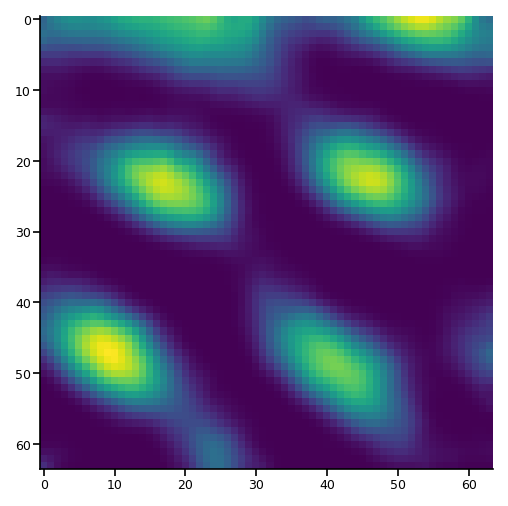

In [8]:
plt.imshow(ratemaps[0,module_indices[0]])

In [9]:
g[0][:,module_indices].shape

(4096, 315)

In [10]:
pca_fits = []
umap_fits = []
for env_i in range(len(g)):
    pca_fit, umap_fit = PCA_UMAP(g[env_i][:,module_indices])
    pca_fits.append(pca_fit)
    umap_fits.append(umap_fit)

In [11]:
panesize = set_size(width=345, mode='max')
figsize = (panesize[0]/3,panesize[1]*2/6)

plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.subplot.wspace"] = 0
plt.rcParams["figure.subplot.hspace"] = 0
plt.rcParams["figure.subplot.left"] = 0
plt.rcParams["figure.subplot.right"] = 1
plt.rcParams["figure.subplot.bottom"] = 0
plt.rcParams["figure.subplot.top"] = 1
plt.rcParams["figure.autolayout"] = True

[ 0. 90.] [ 0. 45.]
[ 0. 90.] [ 0. 45.]
[ 0. 90.] [ 0. 45.]


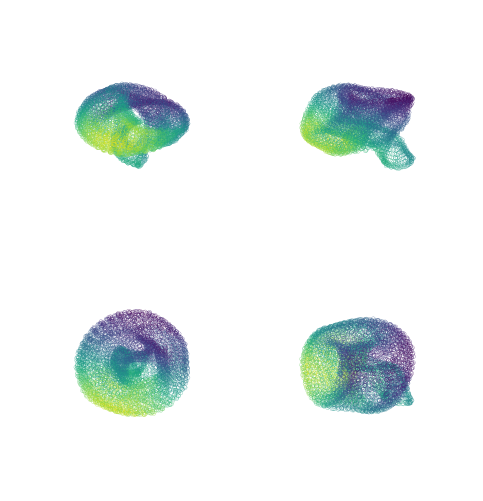

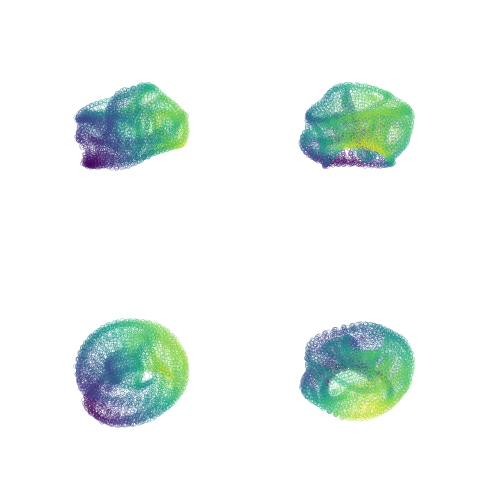

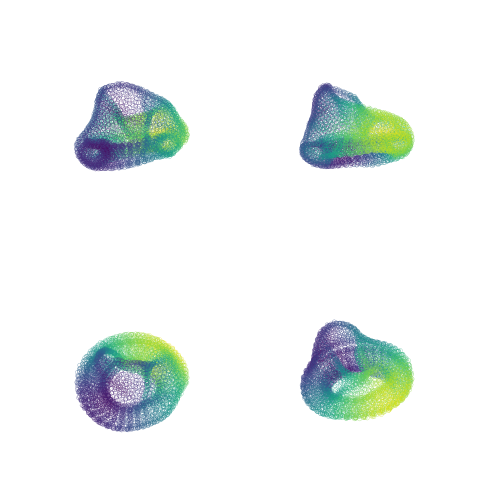

In [12]:
for env_i in range(len(g)):
    fig,axs = scatter3d(umap_fits[env_i],pca_fits[env_i][:,0],nrows=2,ncols=2,azim_elev_title=False,figsize=figsize,s=0.005,alpha=0.8,dpi=300)
    fig.savefig(experiment.paths['experiment'] / f'plots/torei_{selection_process_name}_{env_i}')

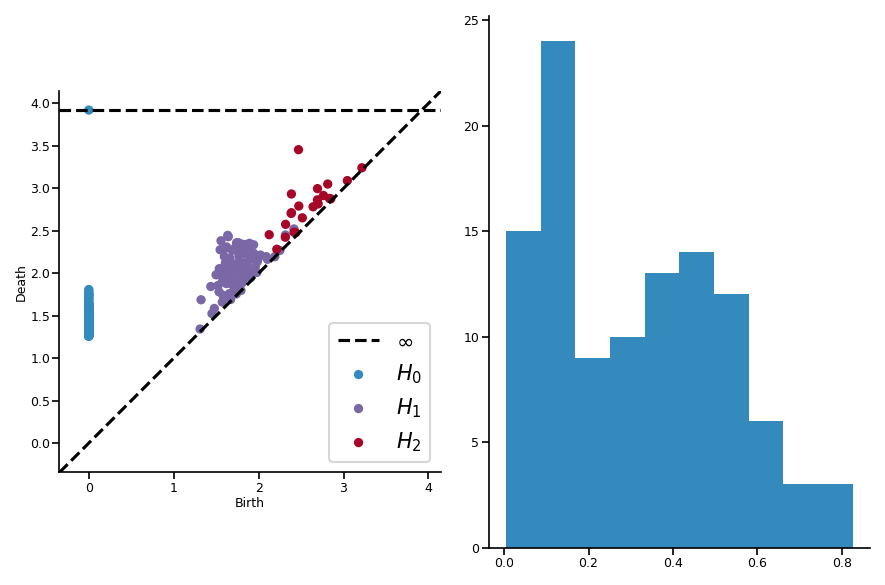

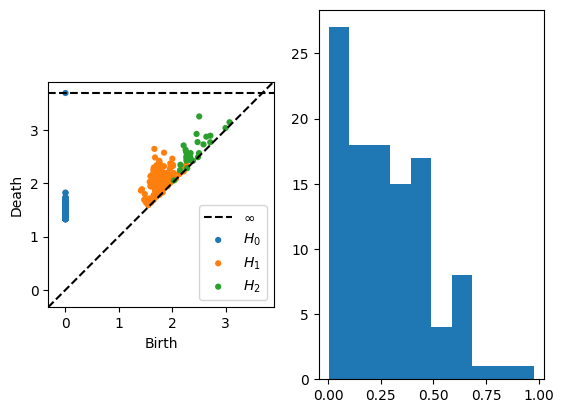

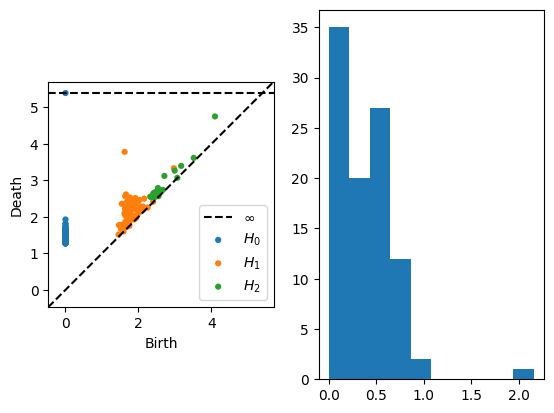

In [13]:
for env_i in range(len(g)):
    fig,axs = plt.subplots(ncols=2)
    #dgms = ripser(g[env_i][:,module_indices],maxdim=2,n_perm=150)['dgms']
    #dgms = ripser(pca_fits[env_i],maxdim=2,n_perm=150)['dgms']
    dgms = ripser(umap_fits[env_i],maxdim=2,n_perm=150)['dgms']
    plot_diagrams(dgms, show=False, ax=axs[0])
    axs[1].hist(dgms[1][:,1] - dgms[1][:,0])